In [1]:
from re import sub
from decimal import Decimal
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("figure", dpi=100)
import numpy as np
import re
import pandas as pd
import seaborn as sns
sns.set_style("ticks")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:


class RoverSettings():
    def __init__(self, zip_code):

        self.repeat_client_class = "CalloutBadge__Badge-rduqlb-0 iuzSam InfoPills__StyledCalloutBadge-sc-1jou7n9-4 jHASEn"
        self.price_class = "PriceAndFavoriteColumn__Price-sc-5y9bmw-3 hYSwMH"
        self.sitter_class = "VerticalLayout-sc-31y83h-0 SearchResultCard__SearchResultCardWrapper-sc-186pa8o-1 csDLKS bsrZxg"
        self.name_class = "NameRow__StyledNameAndBadge-t135c7-1 iecWGG"
        self.sitter_location_class = "InfoColumn__Location-qduboa-2 gJTzwa"

        self.zip_code = zip_code

        self.zip_coords = pd.read_csv(
            "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data")
        self.coords = self.zip_coords[self.zip_coords['ZIP'] == zip_code]
        self.LAT = float(self.coords['LAT'].values)
        self.LON = float(self.coords['LNG'].values)

        self.num_pages = 50


class Sitter():
    def __init__(self):
        self.price = None
        self.repeating_customers = None
        self.name = None
        self.location = None


zip_code = 30307
settings = RoverSettings(zip_code)


start_date = '05%2F14%2F2023'
end_date = '05%2F15%2F2023'


# most similar to us
url = "https://www.rover.com/search/?alternate_results=true&override_check=true&accepts_only_one_client=false&apse=false&bathing_grooming=false&cat_care=false&centerlat={1}&centerlng={2}&dogs_allowed_on_bed=true&dogs_allowed_on_furniture=true&end_date={4}&frequency=onetime&morning_availability=false&midday_availability=false&evening_availability=false&fulltime_availability=true&giant_dogs=false&has_fenced_yard=true&has_house=false&has_no_children=false&is_premier=false&knows_first_aid=false&large_dogs=false&location={4}&location_accuracy=1000&maxprice=150&medium_dogs=true&minprice=1&no_caged_pets=false&no_cats=false&no_children_0_5=false&no_children_6_12=false&non_smoking=true&page={0}&person_does_not_have_dogs=true&pet=&petsitusa=false&pet_type=dog&puppy=false&service_type=overnight-boarding&small_dogs=true&spaces_required=1&start_date={3}&search_score_debug=false&injected_medication=false&special_needs=false&oral_medication=false&more_than_one_client=false&uncrated_dogs=false&unspayed_females=false&non_neutered_males=false&females_in_heat=false&unactivated_provider=false&premier_matching=false&premier_or_rover_match=false&is_member_of_sitter_to_sitter=false&is_member_of_sitter_to_sitter_plus=false&location_type=zip-code&raw_location_types=postal_code&dog_size=small,medium"

# no downselection
#url = "https://www.rover.com/search/?alternate_results=true&override_check=true&accepts_only_one_client=false&apse=false&bathing_grooming=false&cat_care=false&centerlat=40.79164069999999&centerlng=-73.9447994&dogs_allowed_on_bed=false&dogs_allowed_on_furniture=false&end_date=04%2F23%2F2022&frequency=onetime&morning_availability=false&midday_availability=false&evening_availability=false&fulltime_availability=true&giant_dogs=false&has_fenced_yard=false&has_house=false&has_no_children=false&is_premier=false&knows_first_aid=false&large_dogs=false&location=10029&location_accuracy=5161&medium_dogs=false&minprice=0&no_caged_pets=false&no_cats=false&no_children_0_5=false&no_children_6_12=false&non_smoking=false&page={0}&person_does_not_have_dogs=false&pet=&petsitusa=false&pet_type=dog&puppy=false&service_type=overnight-boarding&small_dogs=false&spaces_required=1&start_date=04%2F18%2F2022&search_score_debug=false&injected_medication=false&special_needs=false&oral_medication=false&more_than_one_client=false&uncrated_dogs=false&unspayed_females=false&non_neutered_males=false&females_in_heat=false&unactivated_provider=false&premier_matching=false&premier_or_rover_match=false&is_member_of_sitter_to_sitter=false&is_member_of_sitter_to_sitter_plus=false&location_type=zip-code&raw_location_types=postal_code"

# least possible inputs
#url = "https://www.rover.com/search/?alternate_results=true&override_check=true&centerlat={1}&centerlng={2}&frequency=onetime&location={5}&location_type=zip-code&pet=&pet_type=dog&raw_location_types=postal_code&service_type=overnight-boarding&page={0}&start_date={3}&end_date={4}"


In [3]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()),options=options)
driver.get("https://www.google.com")
print('Done')
driver.quit()



====== WebDriver manager ======
Current firefox version is 110.0
Get LATEST geckodriver version for 110.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.33.0\geckodriver.exe] found in cache


Done


In [4]:
def get_sitters(i, sitter_divs, settings):

    s = Sitter()

    name_string = str(sitter_divs[i].find(
        "div", {"class": settings.name_class}).text).replace('\xa0', '')
    s.name = name_string

    price_string = sitter_divs[i].find(
        "div", {"class": settings.price_class}).string

    s.price = float(Decimal(sub(r'[^\d.]', '', price_string)))

    try:
        repeated_clients_string = sitter_divs[i].find(
            "span", {"class": settings.repeat_client_class}).string
        if str.endswith(repeated_clients_string, 'repeat clients'):
            rc = int(re.findall(r'\d+', repeated_clients_string)[0])
            s.repeating_customers = rc
    except:
        s.repeating_customers = 0

    print(s.name, s.price, s.repeating_customers)

    return s



In [5]:

import unittest

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(
    GeckoDriverManager().install()), options=options)


class TestNotebook(unittest.TestCase):

    def test_get_url(self):

        zip_code = 10029
        settings = RoverSettings(zip_code)

        sitters = []

        start_date = '05%2F14%2F2022'
        end_date = '05%2F15%2F2022'

        driver.get(url.format(1, settings.LAT, settings.LON,
                   start_date, end_date, zip_code))

        html = driver.page_source
        page_html = BeautifulSoup(html)

        sitter_divs = page_html.find_all(
            "div", {"class": settings.sitter_class})

        for i, sitter in enumerate(sitter_divs):

            s = get_sitters(i, sitter_divs, settings)

            sitters.append(s)

        self.assertEqual(len(sitters), 20)


unittest.main(argv=[''], verbosity=2, exit=False)





====== WebDriver manager ======
Current firefox version is 110.0
Get LATEST geckodriver version for 110.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.33.0\geckodriver.exe] found in cache
test_get_url (__main__.TestNotebook) ... c:\Users\pkastner\anaconda3\envs\datascience\lib\site-packages\selenium\webdriver\remote\remote_connection.py:376: DeprecationWarning: HTTPResponse.getheader() is deprecated and will be removed in urllib3 v2.1.0. Instead use HTTResponse.headers.get(name, default).
  if resp.getheader('Content-Type'):
c:\Users\pkastner\anaconda3\envs\datascience\lib\site-packages\selenium\webdriver\remote\remote_connection.py:377: DeprecationWarning: HTTPResponse.getheader() is deprecated and will be removed in urllib3 v2.1.0. Instead use HTTResponse.headers.get(name, default).
  content_type = resp.getheader('Content-Type').split(';')
FAIL

FAIL: test_get_url (__main__.TestNotebook)
----------------------------------------------------------------------


In [6]:
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(
    GeckoDriverManager().install()), options=options)


sitters = []

for page in range(1, settings.num_pages):

    driver.get(url.format(page, settings.LAT, settings.LON,
               start_date, end_date, zip_code))

    html = driver.page_source
    page_html = BeautifulSoup(html)

    sitter_divs = page_html.find_all("div", {"class": settings.sitter_class})

    for i, sitter in enumerate(sitter_divs):

        s = get_sitters(i, sitter_divs, settings)

        sitters.append(s)




====== WebDriver manager ======
Current firefox version is 110.0
Get LATEST geckodriver version for 110.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.33.0\geckodriver.exe] found in cache


In [10]:
sitters

[]

In [7]:
keys_in_class = vars(sitters[0]).keys()

df = pd.DataFrame([[getattr(i,j) for j in keys_in_class] for i in sitters], columns = keys_in_class)
df = df.drop_duplicates()

df.to_csv("results.csv", index=False)

filtered = df.loc[(df['repeating_customers'] > 1) & (df['repeating_customers'] < 125 ) & (df['price'] < 150 ) ]

filtered.sort_values(by=['repeating_customers']).to_csv("repeating_customers_"+str(zip_code)+".csv")
filtered.sort_values(by=['repeating_customers'])

IndexError: list index out of range

In [8]:
sns.displot(filtered, x="price", y="repeating_customers",binwidth=(5, 5), cbar='True',cbar_kws={'label': 'observations'}, legend= True)
plt.xlim(0, 120)
plt.ylim(0, 100)
plt.savefig('displot_price_rc_'+str(zip_code)+'.png', transparent=False)
plt.show()

NameError: name 'filtered' is not defined

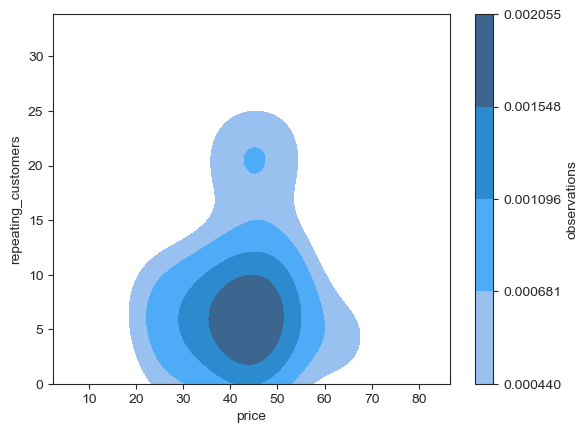

In [ ]:
sns.kdeplot(   data= filtered, x="price", y="repeating_customers",  cbar='True',cbar_kws={'label': 'observations'}, fill=True, legend= True,  levels=5, thresh=.2, clip=((0, 110), (0, 50)))
plt.savefig('kdeplot_price_rc_'+str(zip_code)+'.png', transparent=False)
plt.show()